# Pine & 8th St. Bioretention Notebook


In [1]:
#Load packages

import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
#This is the name of the python module containing the Bioretention Blues submodel.
from BioretentionBlues import BCBlues

In [17]:
#Import the res file, load the others
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
#locsumm = pd.read_excel('inputfiles/QuebecSt_TreeTrench.xlsx',index_col = 0)
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
#chemsumm = pd.read_excel('inputfiles/Kortright_ALL_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
pp = None
fpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/'
res = pd.read_pickle(fpath+'6PPDQ_spiketest.pkl')
#res = pd.read_pickle(fpath+'6PPDQ_simstorm.pkl')
#res = pd.read_pickle(fpath+'/pickles/outputtest.pkl')
res.head()

x        dx  time    dm  maskts  maskss  porositywater  \
6PPDQ 244 0  0.012778  0.025556   0.0  True   False    True           0.42   
          1  0.038333  0.025556   0.0  True   False    True           0.42   
          2  0.063889  0.025556   0.0  True   False    True           0.42   
          3  0.089444  0.025556   0.0  True   False    True           0.42   
          4  0.115000  0.025556   0.0  True   False    True           0.42   

               Awater  Vsubsoil       V2  ...  M6_t1  a7_t1  M7_t1  a8_t1  \
6PPDQ 244 0  3.159053   0.47638  0.47638  ...    0.0    0.0    0.0    0.0   
          1  3.159053   0.47638  0.47638  ...    0.0    0.0    0.0    0.0   
          2  3.159053   0.47638  0.47638  ...    0.0    0.0    0.0    0.0   
          3  3.159053   0.47638  0.47638  ...    0.0    0.0    0.0    0.0   
          4  3.159053   0.47638  0.47638  ...    0.0    0.0    0.0    0.0   

             M8_t1  Mqin  Min_p  M_xf  M_n        dt  
6PPDQ 244 0    0.0   0.0    0.0   0.0  0.0  0.016667  
          1    0.0   NaN    NaN   0.0  0.0  0.016667  
          2    0.0   NaN    NaN   0.0  0.0  0.016667  
          3    0.0   NaN    NaN   0.0  0.0  0.016667  
          4    0.0   NaN    NaN   0.0  0.0  0.016667  

[5 rows x 473 columns]

In [18]:
#Calculate the masses
timeseries = pd.read_excel('inputfiles/timeseries_Pine8th.xlsx')
timeseries = timeseries[timeseries.time<=6]
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)
mbal = bc.mass_balance(res,numc)
mbal_cum = bc.mass_balance_cumulative(numc, mass_balance = mbal,normalized=True)
mbal_cum.head()

time  Min  Mtot  Meff  Mexf  Minp  Minq  Mwater  Madvwater  \
6PPDQ 244  0.000000  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   
      245  0.016667  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   
      246  0.033333  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   
      247  0.050000  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   
      248  0.066667  0.0   NaN   NaN   NaN   NaN   NaN     NaN        NaN   

           Mrwater  ...  Mnetshootspond  Mair  Madvair  Mrair  Mairpond  \
6PPDQ 244      NaN  ...             NaN   NaN      NaN    NaN       NaN   
      245      NaN  ...             NaN   NaN      NaN    NaN       NaN   
      246      NaN  ...             NaN   NaN      NaN    NaN       NaN   
      247      NaN  ...             NaN   NaN      NaN    NaN       NaN   
      248      NaN  ...             NaN   NaN      NaN    NaN       NaN   

           Mpondair  Mnetairpond  Mpond  Madvpond  Mrpond  
6PPDQ 244       NaN          NaN    NaN       NaN     NaN  
      245       NaN          NaN    NaN       NaN     NaN  
      246       NaN          NaN    NaN       NaN     NaN  
      247       NaN          NaN    NaN       NaN     NaN  
      248       NaN          NaN    NaN       NaN     NaN  

[5 rows x 119 columns]

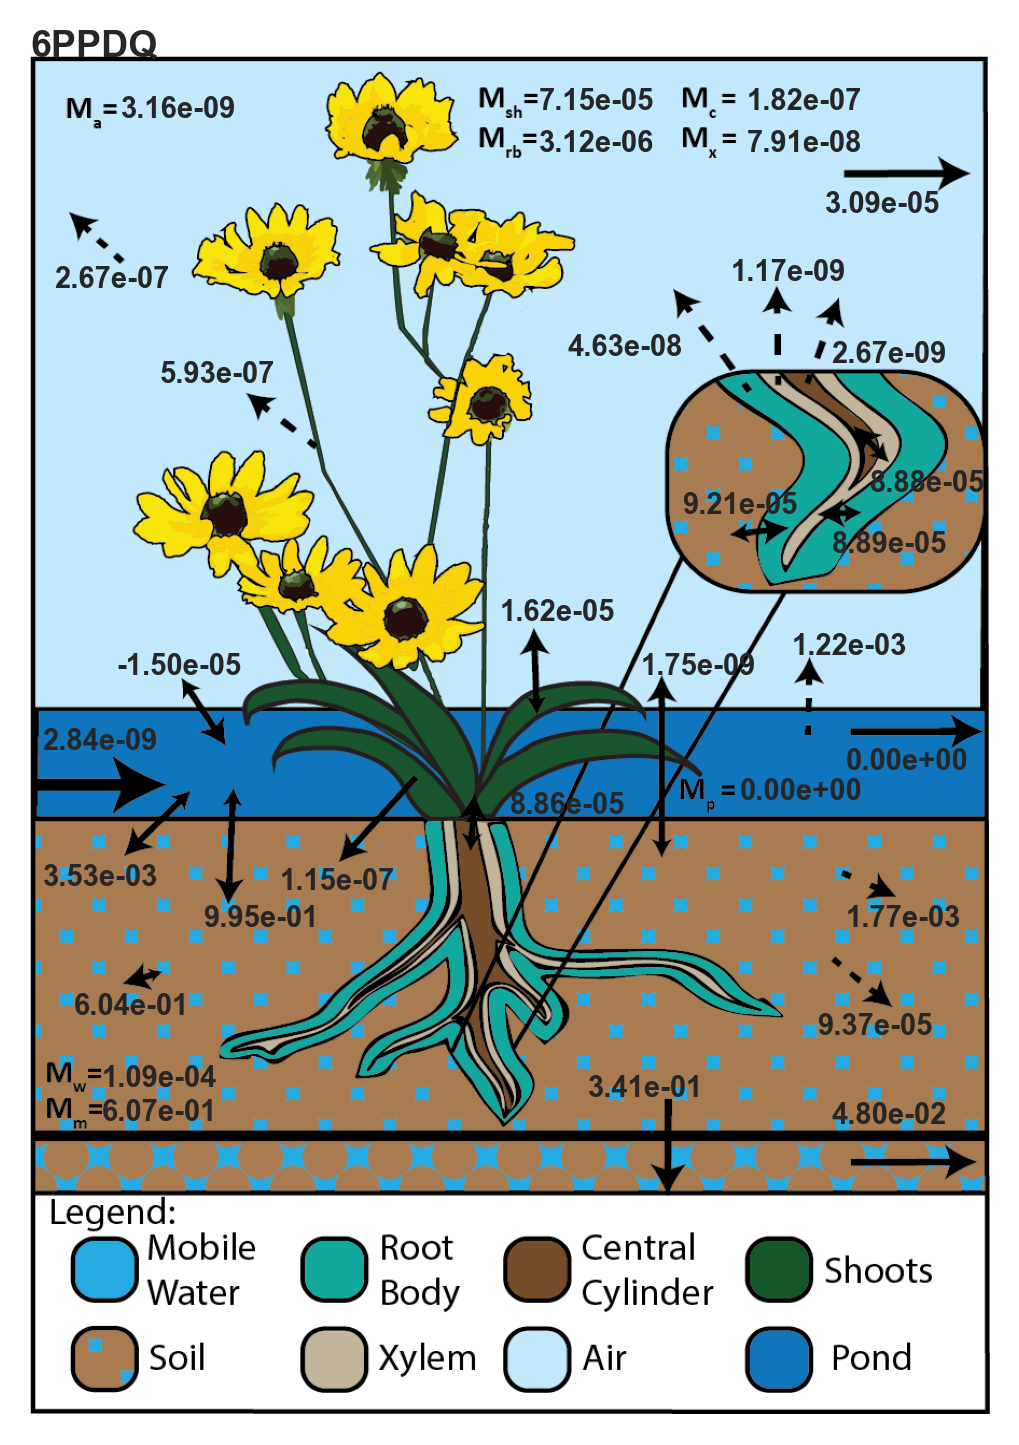

In [19]:
#Plot the figure. Choose the compound and the time to display (in hours).
compound = '6PPDQ'#'Bromide'#use same name as in chemsumm
#Set time (hrs), any time after end gives the end.
time = 1000#6#1000#6#1000
fig,ax = bc.BC_fig(numc,mass_balance=mbal_cum,time = time,compound=compound,figheight=6,fontsize=7,dpi=300)
#Save the figure if you like. I save in pdf then edit in illustrator.
#fig.savefig('Figures/OutputModelFig.pdf', format='pdf',bbox_inches= 'tight')  

In [20]:
Couts = bc.conc_out(numc,timeseries,chemsumm,res)
Couts.loc[:,'6PPDQ_Coutest'] = Couts.loc[:,'6PPDQ_Coutest'] *1e6 #ng/L
Couts.head()
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
Couts.head()

,time,Qout_meas,Qout,6PPDQ_Coutmeas,6PPDQ_Coutest,Bromide_Coutmeas,Bromide_Coutest,Rhodamine_Coutmeas,Rhodamine_Coutest,Rhodamine_n_Coutest
244,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


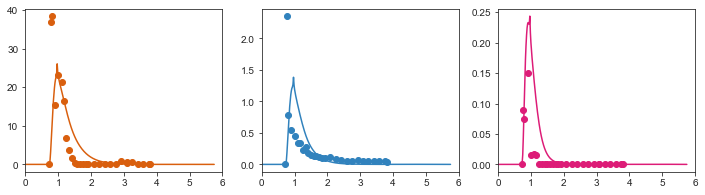

In [21]:
#Model Performance Plots
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
fig,axs = plt.subplots(1,3,figsize=(12,3),sharex='all')
#Plot 1 - Bromide, Benzotriazole, Rhodamine (mg/L)
axs[0].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Bromide_meas (mg/L)']],color='#d95f0e') #fec44f #d95f0e
#axs[0,0].scatter(measdat.loc[:,'Time(hrs)']
#                            ,measdat.loc[:,['Benzotriazole_meas(mg/L)']],color='#756bb1') #bcbddc, #756bb1
axs[1].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['Rhodamine_meas (mg/L)']],color='#3182bd')#9ecae1, #3182bd
#Line Plots
axs[0].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Bromide_Coutest']],color='#d95f0e')#fec44f #d95f0e
#axs[0,0].plot(Couts.loc[:,'time']
#                            ,Couts.loc[:,['Benzotriazole_Coutest']],color='#756bb1')#bcbddc, #756bb1
axs[1].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['Rhodamine_Coutest']],color='#3182bd')#9ecae1, #3182bd
#Plot 2 - 6PPDQ (ng/L)
axs[2].scatter(measdat.loc[:,'Time (hrs)']
                            ,measdat.loc[:,['6PPDQ_meas (ng/L)']],color='#dd1c77') #dd1c77 #c994c7
#Line Plots
axs[2].plot(Couts.loc[:,'time']
                            ,Couts.loc[:,['6PPDQ_Coutest']],color='#dd1c77')#dd1c77 #c994c7
axs[0].set_xlim((0,6))
#axs[0,0].set(xlim=(0, 7.2))
#axs[0,0].set(ylim=(0, 95))
#axs[0,1].set(ylim=(0, 395))
#axs[1,0].set(ylim=(0, 9.5))
fpath = 'D:\OneDrive - UBC\Postdoc\Active Projects\6PPD\Manuscript\Figs\Pythonfigs'
#fig.savefig(fpath+'testvsest_20220822.pdf', format='pdf',bbox_inches= 'tight')  

OSError: [Errno 22] Invalid argument: 'D:\\OneDrive - UBC\\Postdoc\\Active Projects\x06PPD\\Manuscript\\Figs\\Pythonfigstestvsest_20220822.pdf'

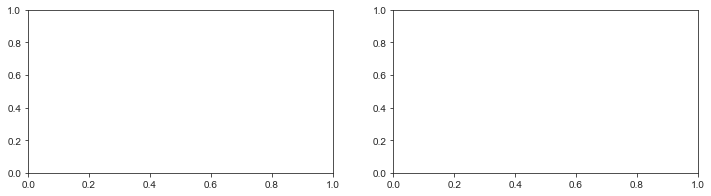

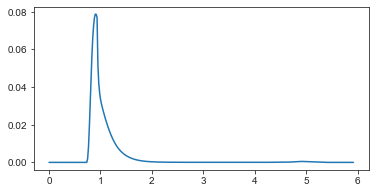

In [72]:
#Model Performance Plots
measdat = pd.read_excel('Tracer_test_measurements.xlsx')
fig,axs = plt.subplots(1,2,figsize=(12,3),sharex='all')
#Plot 1 - Bromide, Benzotriazole, Rhodamine (mg/L)
#axs[0].scatter(measdat.loc[:,'Time (hrs)']
#                            ,measdat.loc[:,['Bromide_meas (mg/L)']],color='#d95f0e') #fec44f #d95f0e
#axs[0,0].scatter(measdat.loc[:,'Time(hrs)']
#                            ,measdat.loc[:,['Benzotriazole_meas(mg/L)']],color='#756bb1') #bcbddc, #756bb1
#axs[0,0].scatter(measdat.loc[:,'Time(hrs)']
#                            ,measdat.loc[:,['Rhodamine_meas(mg/L)']],color='#3182bd')#9ecae1, #3182bd
#Line Plots
#axs[0].plot(Couts.loc[:,'time']
#                            ,Couts.loc[:,['Bromide_Coutest']],color='#d95f0e')#fec44f #d95f0e
#axs[0,0].plot(Couts.loc[:,'time']
#                            ,Couts.loc[:,['Benzotriazole_Coutest']],color='#756bb1')#bcbddc, #756bb1
#axs[0,0].plot(Couts.loc[:,'time']
#                            ,Couts.loc[:,['Rhodamine_Coutest']],color='#3182bd')#9ecae1, #3182bd
#Plot 2 - 6PPDQ (ng/L)
#axs[1].scatter(measdat.loc[:,'Time (hrs)']
#                            ,measdat.loc[:,['6PPDQ_meas (ng/L)']],color='#dd1c77') #dd1c77 #c994c7
#Line Plots
fig,axs = plt.subplots(1,1,figsize=(6,3),sharex='all')
plt.plot(Couts.loc[Couts.time<6,'time']
                            ,Couts.loc[Couts.time<6,['6PPDQ_Coutest']])#dd1c77 #c994c7
#axs[0,0].set(xlim=(0, 7.2))
#axs[0,0].set(ylim=(0, 95))
#axs[0,1].set(ylim=(0, 395))
#axs[1,0].set(ylim=(0, 9.5))
fpath = 'D:\OneDrive - UBC\Postdoc\Active Projects\6PPD\Manuscript\Figs\Pythonfigs'
fig.savefig(fpath+'testvsest_20220822.pdf', format='pdf',bbox_inches= 'tight')  

In [13]:
res = pd.DataFrame(columns = ['Elapsed Time (s)','Precip (mm/hr)','Runoff (L/s)'])
res.loc[]
res

,Elapsed Time (s),Precip (mm/hr),Runoff (L/s)


In [19]:
#Try to incorporate SWMM
import pyswmm
from pyswmm import Simulation, RainGages
import pdb
swmmpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Data/Pine and 8th South - Bioretention Template/'
#swmmpath = 'C:/Users/trodge01/My Documents/EPA SWMM Projects/'
#sim = Simulation(swmmpath+'test3.inp')
#sim.close()
res = pd.DataFrame(columns = ['DateTime','Precip','Runoff'])
with Simulation(swmmpath+'pine8_catchmentonly.inp') as sim:
    pdb.set_trace()
    rg1 = RainGages(sim)["Gauge1"]
    subctch = pyswmm.Subcatchments(sim)["Roadway"]
    sim.end_time = datetime.datetime(2020, 1, 2, 0, 0)
    for ind,step in enumerate(sim):
        res.loc[ind,'DateTime'] = sim.current_time
        res.loc[ind,'Precip'] = rg1.total_precip
        res.loc[ind,'Runoff'] = subctch.runoff
        #pdb.set_trace()
        #rg1.total_precip = 1.0 #mm/hr
        #print()
        #print(rg1.total_precip)
        #print(subctch.runoff)
        pass
res
    #sim.execute()
    #sim.report()
res.Runo

> c:\users\trodge01\appdata\local\temp\ipykernel_32640\210448138.py(12)<module>()

ipdb> sim.start_time
datetime.datetime(2020, 1, 1, 0, 0)
ipdb> sim.end_time
datetime.datetime(2020, 1, 4, 12, 0)
ipdb> sim.end_time = datetime.datetime(2020, 1, 2, 0, 0)
ipdb> c


,DateTime,Precip,Runoff
0,2020-01-01 00:00:05,0.0,0.0
1,2020-01-01 00:00:10,0.0,0.0
2,2020-01-01 00:00:15,0.0,0.0
3,2020-01-01 00:00:20,0.0,0.0
4,2020-01-01 00:00:25,0.0,0.0
...,...,...,...
17274,2020-01-01 23:59:35,0.0,0.0
17275,2020-01-01 23:59:40,0.0,0.0
17276,2020-01-01 23:59:45,0.0,0.0
17277,2020-01-01 23:59:50,0.0,0.0


In [67]:
#full_series = pd.read_excel('inputfiles/2014_timeseries.xlsx')
SWMMseries = full_series[:5000]
#ramp = np.array([6.0,3.0,2.0,1.0,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60])
#len(ramp) - 1
t = 2470
dt = 6
SWMMend = int(dt *60)-1
np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])
#SWMMseries.loc[t:t+SWMMend,'Precip']
#timeseries.loc[:,'r_shift'] = timeseries.Runoff.shift(-1*60)
#timeseries.loc[t:t+60,'r_shift']

20.6

In [ ]:
#Run to get swmm outputs from full-year timeseries
full_series = pd.read_excel('inputfiles/2014_timeseries.xlsx')
#SWMMseries.head()
timeseries = pd.DataFrame(columns = ['elapsedtime','precip','runoff'])
ind = 0
SWMMseries = full_series[:5000]
SWMMseries.loc[:,'p_shift'] = SWMMseries.Precip.shift(15*60)#Start changing X hrs before precipitation
#Chose 15 hrs to give 6,3,2,1,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60
SWMMseries.loc[:,'r_shift'] = SWMMseries.Runoff.shift(1*60)#Start changing X hrs after Qin ends
pswitch = False #To ramp up
rswitch = True #To ramp down. Start true.
ramp = np.array([6.0,3.0,2.0,1.0,0.5,0.5,0.25,0.25,0.25,0.25,10/60,10/60,10/60,10/60,5/60,5/60,5/60,5/60,1/60])
rampstep = 0
dt = 6.0 #Hours. Baseline is 6 hours in dry periods, 1 minute in wet periods
while t < len(SWMMseries.index):
    pdb.set_trace()
    if pswitch == True: #Ramp timestep down to 1 minute and stay there until rswitch activates
        rampstep = ramp + 1
        if rampstep >= len(ramp):#stay at 1/60 if there
            rampstep = len(ramp)-1       
        #Start to ramp up to 6 hrs if the next X minutes all have zero flow. 
        if  (rswitch == False) & (SWMMseries.loc[t:t+60,'r_shift'] != 0):
            rswitch = True
            pswitch = False
            
    elif rswitch == True:
        rampstep = rampstep - 1
        if rampstep < 0:#stay at 6 hrs if there
            rampstep = 0 
        #Start to ramp down to 1 minute when precipitation appears
        if (pswitch == False) & (SWMMseries.loc[t,'p_shift'] != 0):
            pswitch = True
            rswitch = False
            rampstep = 0
    #Now, we are going to make the timeseries for the BC Blues model 
    #Each timestep represents the average from t to t + dt (not including the last step)
    #Elapsed time at the beginning of the timestep (hrs)
    timeseries.loc[ind,'elapsedtime'] += dt
    #Then, change dt
    dt = ramp[rampstep]
    #Next, add the accumulated precipitation and runoff across the timestep
    SWMMend = ind(dt *60)-1 #Averaging period
    timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])
    timeseries.loc[ind,'precip'] = np.sum(SWMMseries.loc[t:t+SWMMend,'Precip'])
    #To finish, we will go to the next t based on dt
    t += int(dt*60)
    ind += 1
    #Ramp up to 1 minute from 6 hours when pswitch triggers

        
    

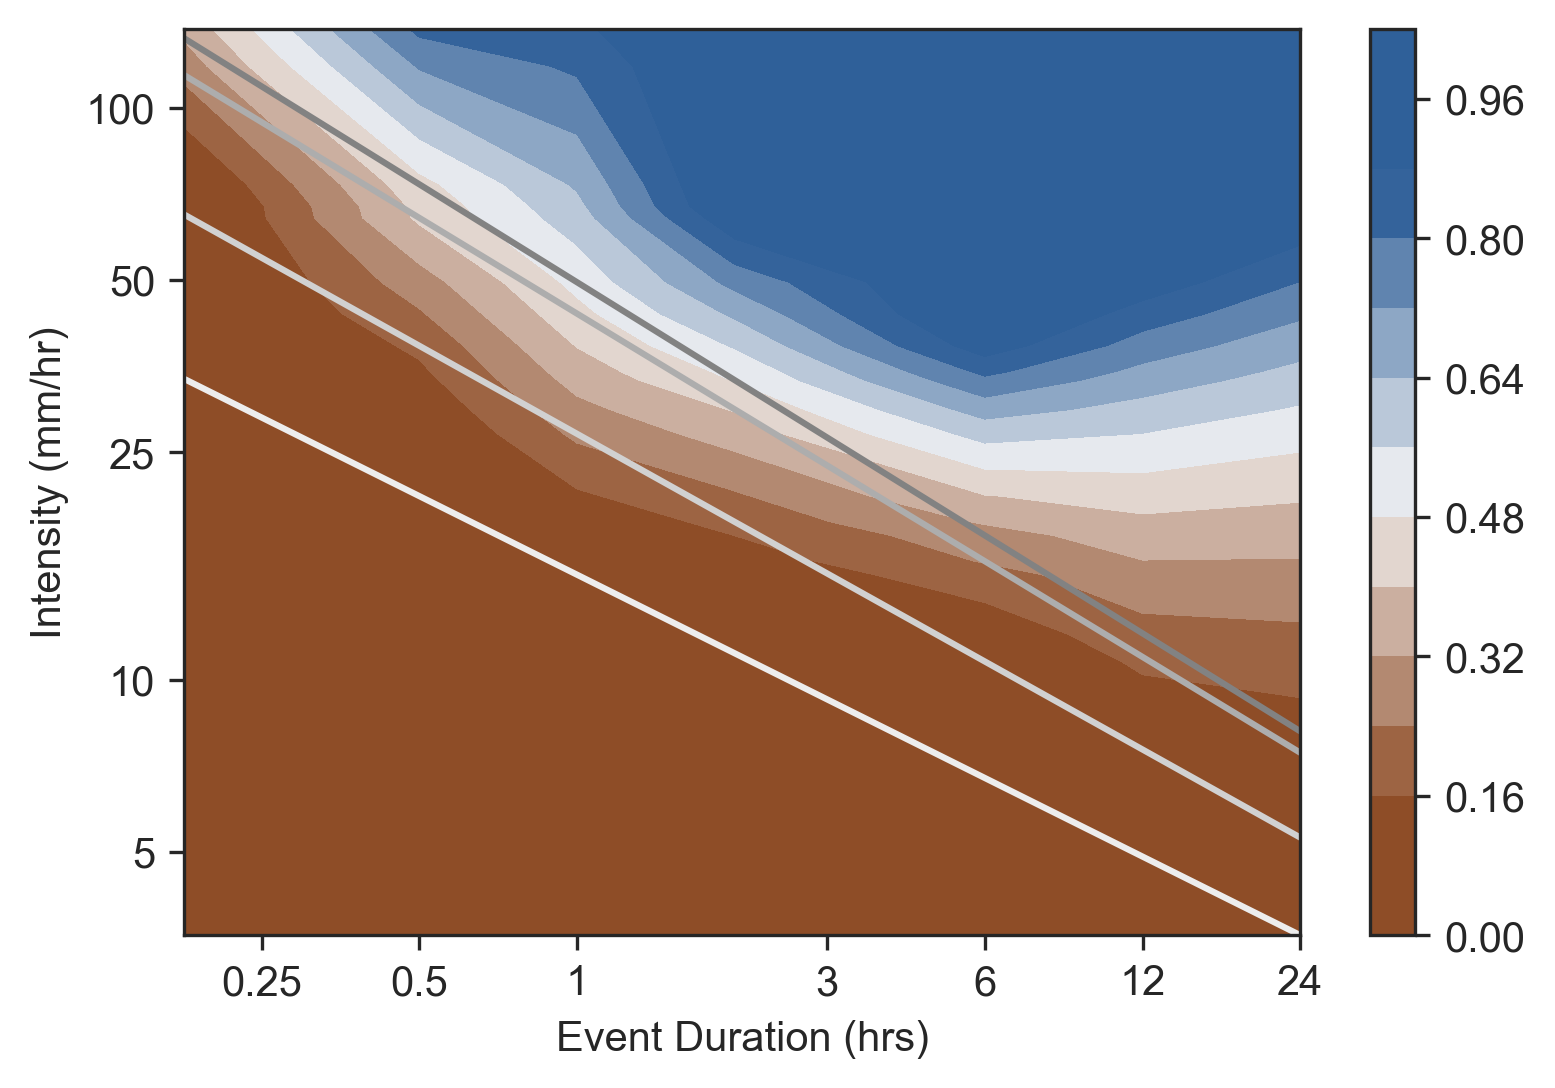

In [6]:
#Plot system performance on IDF curves
#Inputs
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_defaults.pkl'
outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_results.pkl'
#outpath = 'D:/GitHub/Vancouver_BC_Modeling/Pickles/IDF_nodrain.pkl'
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
locsumm = pd.read_excel('inputfiles/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_Pine8th.xlsx',index_col = 0)
timeseries = pd.read_excel('inputfiles/timeseries_IDFstorms.xlsx')
pltdata = pd.read_pickle(outpath)
#Define the x and y axes
xticks = [0.25,0.5,1,3, 6,12,24]
xticks = [np.log10(xticks),xticks]
yticks = [5,10,25,50,100]
yticks = [np.log10(yticks),yticks]
#Define the variables to plot
pltvars=['pct_stormsewer','LogD','LogI']
#pltvars=['RQ_av','LogD','LogI']

#Define other parameters
#Limit of interpolation - values outside of these limits will be set to these. Use "none" for no limits
interplims = [0.,1.]
#interplims = [0.,3.5]
vlims = [0.15,0.85]#[0.15,3.5]#
#pdb.set_trace()
#define the colormap - default is brown-blue
cmap = None
#cmap = sns.cubehelix_palette(start=.75, rot=-.5,light=0.85, as_cmap=True)
#cmap = sns.cubehelix_palette(n_colors = 7,start=1.40, rot=-0.9,gamma = 0.3, hue = 0.9, dark=0.1, light=.95,as_cmap=True,reverse=True)
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) 
fig,ax = bc.plot_idfs(pltdata,pltvars=pltvars,cmap=cmap,vlims=vlims,interplims=interplims,
                      xticks=xticks,yticks=yticks,figsize=(6,4))
ax.set_xlabel('Event Duration (hrs)')
ax.set_ylabel('Intensity (mm/hr)')
figpath = 'D:/OneDrive - UBC/Postdoc/Active Projects/6PPD/Manuscript/Figs/Pythonfigs/'
figname = 'IDF_foc_D_nodrain'
#fig.savefig(figpath+figname+'.pdf',format='pdf')
#fig.savefig()

In [7]:
[pltdata.RQ_sum.sum(),pltdata.RQ_av.mean()]


[29137.68910447152, 1.4470897911645824]

In [40]:
pltdata

,Duration,Frequency,pct_advected,pct_transformed,pct_sorbed,pct_overflow,pct_stormsewer,MEC_ngl,Conc_red,RQ_av,RQ_sum,dur_num,LogD,Intensity,LogI
Compound,,,,,,,,,,,,,,,
6PPDQ,10min,2yr,0.044429,0.004290,0.951282,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,-0.778151,34.581918,1.538849
6PPDQ,10min,10yr,0.244689,0.007587,0.747724,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,-0.778151,67.240941,1.827634
6PPDQ,10min,100yr,0.442150,0.006774,0.551077,0.234441,0.234441,1282.565979,-0.282566,0.358822,108.005556,0.166667,-0.778151,118.178784,2.072540
6PPDQ,10min,200yr,0.491248,0.006335,0.502417,0.298855,0.298855,1375.441986,-0.375442,0.432907,130.305030,0.166667,-0.778151,137.164086,2.137240
6PPDQ,30min,2yr,0.220188,0.005931,0.773881,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,-0.301030,20.946749,1.321117
6PPDQ,30min,10yr,0.398275,0.007382,0.594343,0.158693,0.158693,1188.360711,-0.188361,0.540258,162.617781,0.500000,-0.301030,38.351765,1.583785
6PPDQ,30min,100yr,0.571344,0.005896,0.422760,0.392172,0.392172,1447.473158,-0.447473,1.316115,396.150548,0.500000,-0.301030,64.170545,1.807336
6PPDQ,30min,200yr,0.606905,0.005550,0.387544,0.441477,0.441477,1542.322416,-0.542322,1.456293,438.344266,0.500000,-0.301030,73.452274,1.866005
6PPDQ,1hr,2yr,0.282105,0.007888,0.710007,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,15.266615,1.183743
